In [1]:
from omegaconf import OmegaConf
import os, sys

#Add LaTex to PATH
os.environ["PATH"] += os.pathsep + "/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
import time
import scienceplots
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import CuboidTransformerModel
from models.lightning import SEVIRPLModule

/pscratch/sd/a/akhot/earth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model_name="earthformer_edl_1_drop_0_pretrain"
save_dir = "../models/experiments/{}/".format(model_name)
oc_file = os.path.join(save_dir, "cfg.yaml")
checkpoints = os.path.join(save_dir, "checkpoints/")
oc_from_file = OmegaConf.load(open(oc_file, "r"))

In [5]:
dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

In [11]:
total_num_steps = SEVIRPLModule.get_total_num_steps(
    epoch=oc_from_file.optim.max_epochs,
    num_samples=dm.num_train_samples,
    total_batch_size=oc_from_file.optim.total_batch_size,
)
pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)

/pscratch/sd/a/akhot/earth/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
test_loader = dm.test_dataloader()

In [8]:
import sys
sys.path.append('../') # add sevir module to path
from utils.visualization.sevir_cmap import get_cmap, VIL_COLORS, VIL_LEVELS
from matplotlib.patches import Patch

plt.style.use('science')

# Get colormaps for encoded types
cmap_dict = lambda s: {'cmap': get_cmap(s, encoded=True)[0],
                           'norm': get_cmap(s, encoded=True)[1],
                           'vmin': get_cmap(s, encoded=True)[2],
                           'vmax': get_cmap(s, encoded=True)[3]}

In [13]:
def generate_image(target, save_path):
    
    minutes = [0, 10, 20, 30, 40, 50, 60]
    frames = []
    fig,axs = plt.subplots(1,7,figsize=(22,15))
    
    for j in range(7):
        axs[j].set_xticks([])
        axs[j].set_yticks([])
        axs[j].set_xticklabels([])
        axs[j].set_yticklabels([])
            
    
    for idx, i in enumerate(minutes):
        frame_idx = int(i / 5)

        axs[idx].set_xlabel("{} Minutes".format(str(i)), fontsize=24)
        f0 = axs[idx].imshow(target[0, frame_idx, :, :, 0],**cmap_dict('vil'))

    # Legend of thresholds
    num_thresh_legend = len(VIL_LEVELS) - 1
    legend_elements = [Patch(facecolor=VIL_COLORS[i],
                             label=f'{int(VIL_LEVELS[i - 1])}-{int(VIL_LEVELS[i])}')
                       for i in range(1, num_thresh_legend + 1)]
    x_legend = -1.0
    axs[0].legend(handles=legend_elements, loc='center left',
                    bbox_to_anchor=(x_legend, .4),
                    borderaxespad=0, frameon=False, fontsize='20')

    plt.savefig(save_path, dpi=300)
    plt.show()

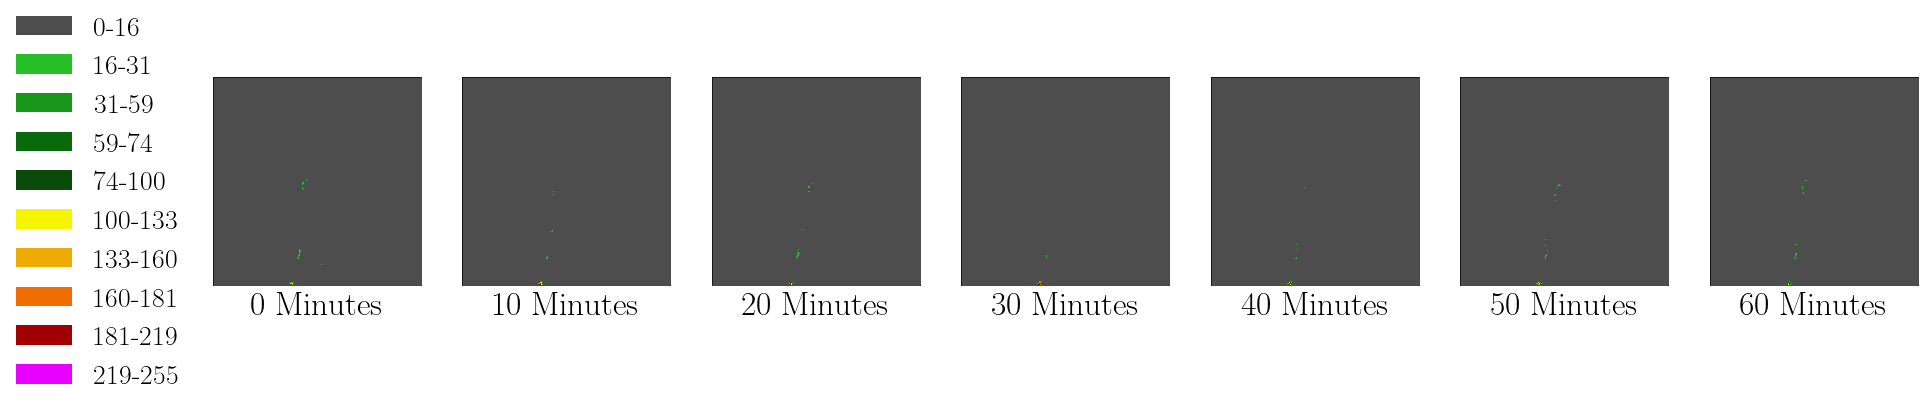

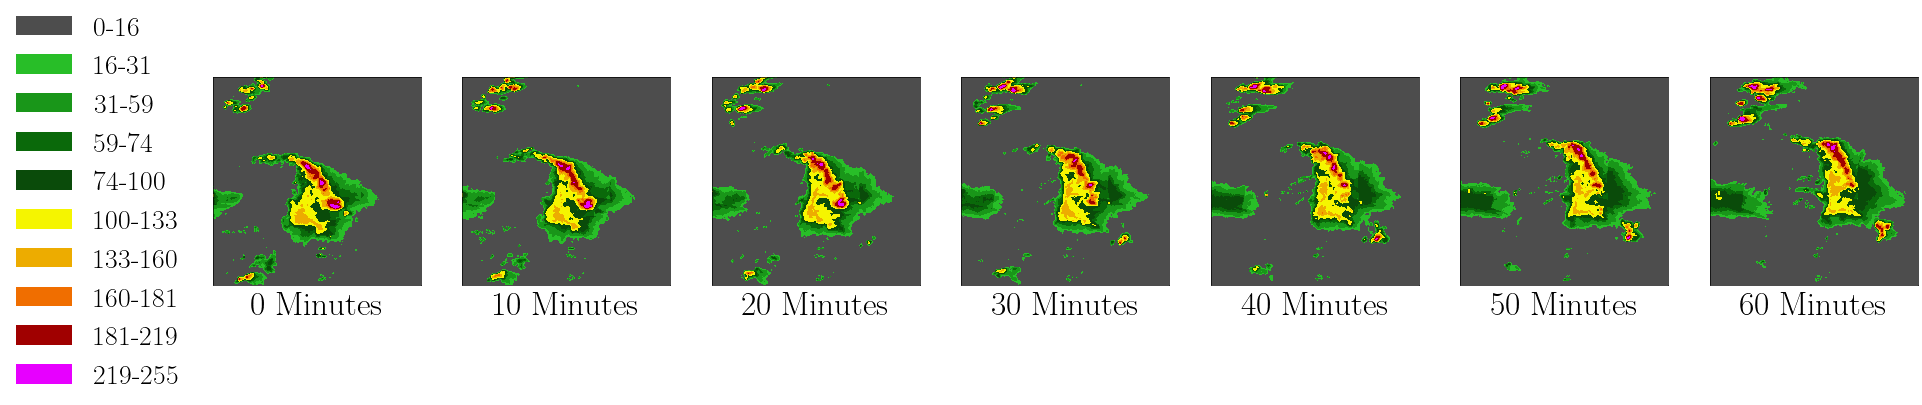

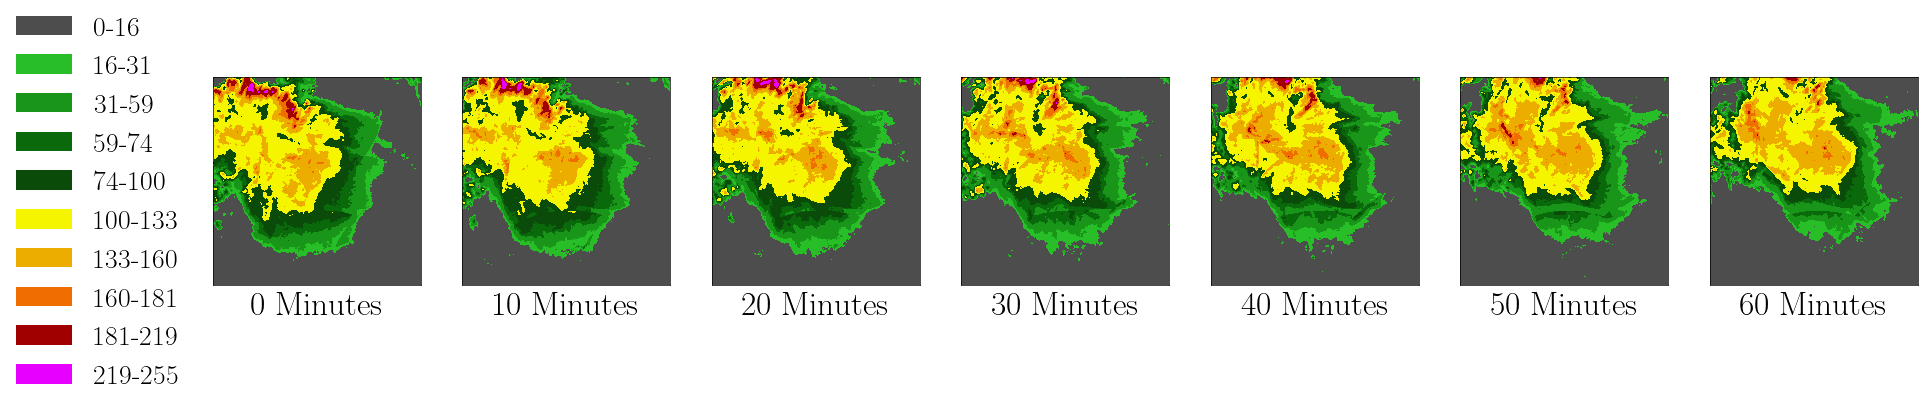

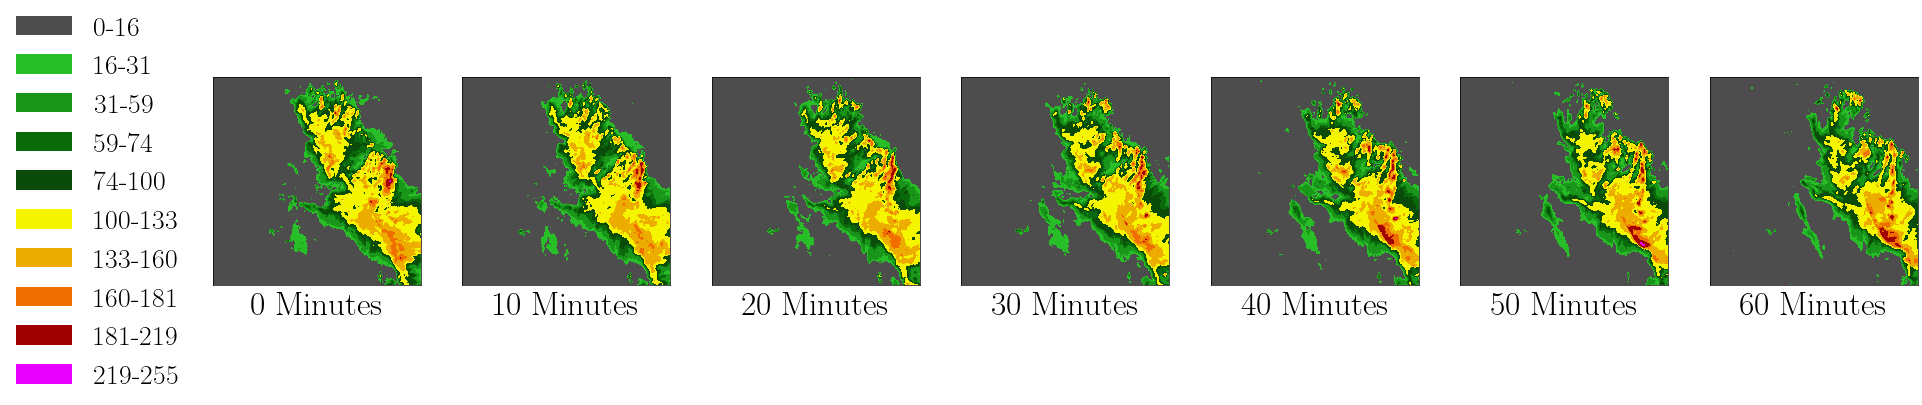

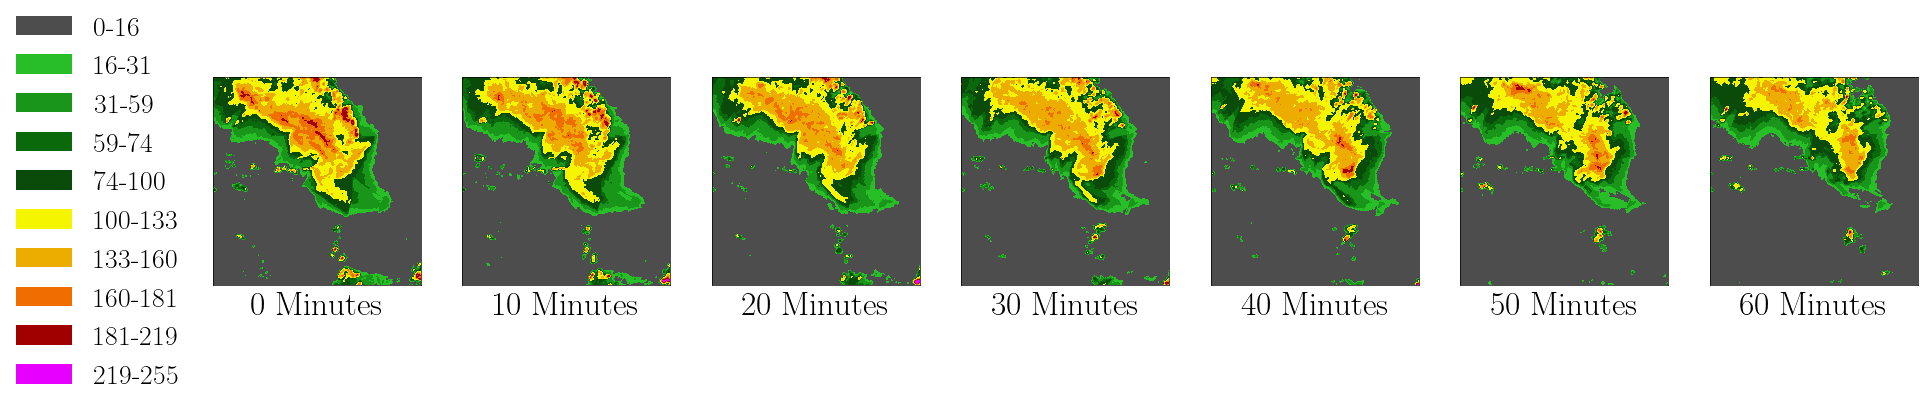

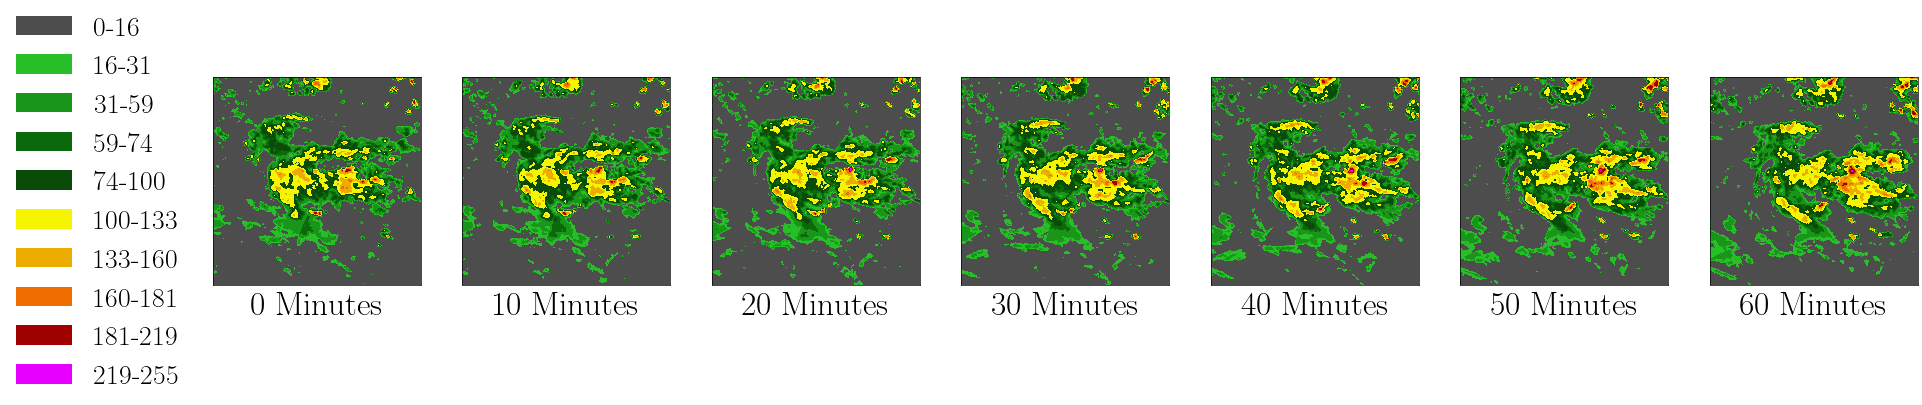

In [15]:
for batch_idx, batch in enumerate(test_loader):
    if batch_idx not in pl_module.test_example_data_idx_list:
        if batch_idx > pl_module.test_example_data_idx_list[-1]:
            break
        continue
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    
    generate_image(x.detach().float().cpu().numpy()* 255,
                   "figures/SEVIR_" + str(batch_idx) + ".pdf")